In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

from transformers import AutoConfig, AutoTokenizer, TFAutoModel



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
config = AutoConfig.from_pretrained('nlpaueb/legal-bert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "_name_or_path": "nlpaueb/legal-bert-base-uncased",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
config

BertConfig {
  "_name_or_path": "nlpaueb/legal-bert-base-uncased",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/config.json
Model config BertConfig {
  "_name_or_path": "nlpaueb/legal-bert-base-uncased",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncase

In [ ]:
# Load the data
data = pd.read_csv('pp_df.csv')

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)


classes = data.label.unique().tolist()
print(classes)

['ARG', 'PRECEDENT', 'RPC', 'REASONING', 'NAME', 'CITATION', 'STATUTE', 'FACTS', 'JUDGE', 'COUNSEL', 'RLC']


In [ ]:

from sklearn.model_selection import train_test_split

#drop all the none values
data = data.dropna()
# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
train, valid = train_test_split(train, test_size=0.25, random_state=42)

print(train.shape, valid.shape, test.shape)

(1370, 2) (457, 2) (457, 2)


In [ ]:
train = train[['sentence','label']]

In [ ]:
train.head()

,sentence,label
1602,appeal dismissed,RPC
1741,thing remains ascertained whether decree passe...,PRECEDENT
872,sum came rent receiver obtained plaintiff s pr...,FACTS
1360,mister kilobyte b asthana respondent,COUNSEL
1566,judgment solicit delivered judge fazl ali,JUDGE


In [ ]:
test = test[['sentence','label']]

In [ ]:
test.head()
len(test)

457

In [ ]:
test.head()


,sentence,label
383,jai gopal sethi rl kohli cavea tor 1951,COUNSEL
2185,appeal dismissed,RPC
2241,investigation regular court necessary aggrieve...,RPC
1975,1896 vithalrao died succeeded eldest son ganpa...,FACTS
810,appellant acquitted,RPC


In [ ]:
max_seq_len = 128
input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
bert_model = TFAutoModel.from_pretrained(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased', config=config, from_pt=True)
bert_output = bert_model(input_ids)

bert_output_cls = bert_output.pooler_output


cls_out = keras.layers.Dropout(0.5)(bert_output_cls)
logits = keras.layers.Dense(units=11, activation="softmax")(cls_out)

model = keras.Model(inputs=input_ids, outputs=logits)
model.build(input_shape=(None, max_seq_len))





loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/pytorch_model.bin
Loading PyTorch weights from /root/.cache/huggingface/hub/models--nlpaueb--legal-bert-base-uncased/snapshots/15b570cbf88259610b082a167dacc190124f60f6/pytorch_model.bin
PyTorch checkpoint contains 133,577,846 parameters
Loaded 109,482,240 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another arc

In [ ]:
#preprocessing
class Classifier:
  DATA_COLUMN = "sentence"
  LABEL_COLUMN = "label"

  def __init__(self, train, test, tokenizer, classes, max_seq_len=128):
    self.tokenizer = tokenizer
    self.max_seq_len = 128
    self.classes = classes

    train, test = map(lambda df: df.reindex(df[Classifier.DATA_COLUMN].str.len().sort_values().index), [train, test])

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label = row[Classifier.DATA_COLUMN], row[Classifier.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:

classes = train.label.unique().tolist()
print(classes)

['RPC', 'PRECEDENT', 'FACTS', 'COUNSEL', 'JUDGE', 'REASONING', 'STATUTE', 'ARG', 'RLC', 'NAME', 'CITATION']


In [ ]:
data = Classifier(train, test, tokenizer, classes, max_seq_len=128)


1370it [00:00, 4627.94it/s]
<ipython-input-43-1744e357f7d9>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x), np.array(y)
457it [00:00, 4856.01it/s]

max seq_len 162


In [ ]:
print(data.test_x.shape)
print(data.test_y.shape)
print(data.train_x.shape)
print(data.train_y.shape)



(457, 128)
(457,)
(1370, 128)
(1370,)


In [ ]:
data.train_x[0]


array([101, 556, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
data.train_x[2]


array([101, 753, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPo   109482240 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 128, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                           

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
history = model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=20,
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


78/78 [==============================] - 82s 521ms/step - loss: 0.0382 - acc: 0.9903 - val_loss: 1.5615 - val_acc: 0.5985
Epoch 2/25
78/78 [==============================] - 35s 455ms/step - loss: 0.0246 - acc: 0.9951 - val_loss: 1.6395 - val_acc: 0.6058
Epoch 3/25
78/78 [==============================] - 35s 454ms/step - loss: 0.0192 - acc: 0.9968 - val_loss: 1.6850 - val_acc: 0.6131
Epoch 4/25
78/78 [==============================] - 35s 453ms/step - loss: 0.0221 - acc: 0.9951 - val_loss: 1.7401 - val_acc: 0.6131
Epoch 5/25
78/78 [==============================] - 35s 451ms/step - loss: 0.0244 - acc: 0.9943 - val_loss: 1.7983 - val_acc: 0.5474
Epoch 6/25
78/78 [==============================] - 35s 452ms/step - loss: 0.0378 - acc: 0.9919 - val_loss: 2.0717 - val_acc: 0.5620
Epoch 7/25
78/78 [==============================] - 35s 452ms/step - loss: 0.0147 - acc: 0.9984 - val_loss: 1.8393 - val_acc: 0.6204
Epoch 8/25
78/78 [==============================] - 35s 451ms/step - loss: 0.047

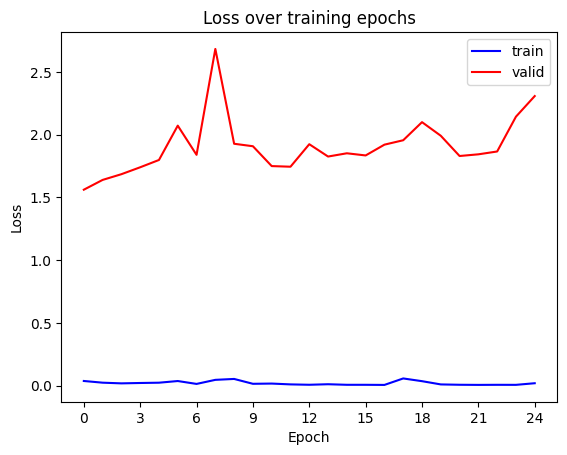

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'],'b')
ax.plot(history.history['val_loss'],'r')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Loss over training epochs')
plt.show();

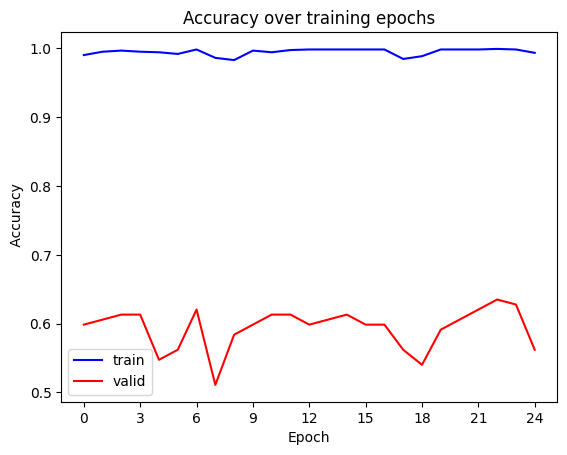

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'],'b')
ax.plot(history.history['val_acc'],'r')
plt.ylabel(' Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

15/15 [==============================] - 4s 271ms/step - loss: 1.9451 - acc: 0.7090
train acc 0.9554744362831116
test acc 0.7089715600013733


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
y_pred

15/15 [==============================] - 7s 276ms/step


array([ 3,  6,  4,  4,  3,  3,  0,  0,  7,  0,  0,  0,  3,  0,  0,  0,  0,
        0,  0,  3,  1,  7,  0,  7,  4,  3,  0,  3,  0,  3,  0,  0,  6,  3,
        6,  0,  8,  3,  3,  3,  3,  3,  1,  3,  0,  1,  3,  1,  2,  3,  3,
        1,  7,  8,  6,  8,  3,  3,  5,  3,  0,  3,  3,  4,  5,  3,  4,  6,
        3,  2,  0,  8,  4,  3,  8,  4,  2,  4,  3,  7,  2,  4,  9,  4,  4,
        4,  4,  7,  6,  4,  0,  4,  4,  9,  6,  4,  1,  8,  1,  3,  6,  4,
        3,  3,  9,  8,  3,  0,  4,  2,  5,  3,  0,  0,  3,  9,  8,  9,  4,
        4,  9,  4,  7,  4,  2,  9,  7,  3,  3,  9,  0,  7,  0,  0,  1,  7,
        9,  3,  7,  7,  3,  9,  4,  0,  8,  3,  9,  4,  8,  3,  9,  3,  2,
        7,  3,  2,  7,  9,  9,  9,  0,  2,  4,  8,  9,  2,  2,  3,  5,  3,
        8,  9,  0,  8, 10, 10, 10, 10,  5,  3,  0,  3, 10, 10, 10,  7,  2,
        9,  3,  5, 10,  8,  0,  3, 10, 10,  0, 10,  8,  9,  2,  6,  8,  9,
        8,  8,  7,  0,  3,  9,  3,  1,  2,  1, 10,  7,  6,  6,  6,  6,  8,
       10,  3,  8,  9, 10

In [ ]:
print(classification_report(data.test_y,y_pred, target_names=classes))


              precision    recall  f1-score   support

         RPC       0.60      0.72      0.65        46
   PRECEDENT       0.84      0.60      0.70        43
       FACTS       0.69      0.56      0.62        62
     COUNSEL       0.91      0.98      0.94        50
       JUDGE       0.96      0.93      0.95        29
   REASONING       0.46      0.14      0.22        42
     STATUTE       0.60      0.74      0.66        46
         ARG       0.57      0.82      0.67        44
         RLC       0.56      0.65      0.60        48
        NAME       0.88      1.00      0.94        22
    CITATION       1.00      1.00      1.00        25

    accuracy                           0.71       457
   macro avg       0.73      0.74      0.72       457
weighted avg       0.71      0.71      0.69       457

